In [6]:
#!conda config --add channels conda-forge
#!pip install -y libsndfile
#!pip uninstall pywt 
#!pip uninstall soundfile 
#!pip uninstall librosa 

In [20]:
import os
import sys
import types
#import ibm_boto3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from zipfile import ZipFile
from botocore.client import Config

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score


import soundfile as sf
import librosa

import pywt

    
%matplotlib notebook

In [21]:
def __iter__(self): return 0

#
# INSERT YOUR CONNECTION TO audio_data.zip HERE
# USE Insert StreamingBody object
#

data_bytes = BytesIO(open('./data/audio_data.zip','rb').read())
zip_file = ZipFile(data_bytes)

The data used for this demonstration comes from the Urban Sounds Dataset. This dataset and its taxonomy is presented in J. Salamon, C. Jacoby and J. P. Bello, A Dataset and Taxonomy for Urban Sound Research, 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

For simplicity the dataset is sampled and a subset of 20 audio clips from two categories are used - air conditioner (AC) and drill.

In [22]:
ZipFile.namelist(zip_file)

['audio_data/',
 'audio_data/ac/',
 'audio_data/ac/101729-0-0-1.wav',
 'audio_data/ac/101729-0-0-11.wav',
 'audio_data/ac/101729-0-0-12.wav',
 'audio_data/ac/101729-0-0-13.wav',
 'audio_data/ac/101729-0-0-14.wav',
 'audio_data/ac/101729-0-0-16.wav',
 'audio_data/ac/101729-0-0-17.wav',
 'audio_data/ac/101729-0-0-18.wav',
 'audio_data/ac/101729-0-0-19.wav',
 'audio_data/ac/101729-0-0-21.wav',
 'audio_data/ac/101729-0-0-22.wav',
 'audio_data/ac/101729-0-0-23.wav',
 'audio_data/ac/101729-0-0-24.wav',
 'audio_data/ac/101729-0-0-26.wav',
 'audio_data/ac/101729-0-0-28.wav',
 'audio_data/ac/101729-0-0-29.wav',
 'audio_data/ac/101729-0-0-3.wav',
 'audio_data/ac/101729-0-0-32.wav',
 'audio_data/ac/101729-0-0-33.wav',
 'audio_data/ac/101729-0-0-36.wav',
 'audio_data/drill/',
 'audio_data/drill/103199-4-0-0.wav',
 'audio_data/drill/103199-4-0-3.wav',
 'audio_data/drill/103199-4-0-4.wav',
 'audio_data/drill/103199-4-0-5.wav',
 'audio_data/drill/103199-4-0-6.wav',
 'audio_data/drill/103199-4-1-0.wav

In [23]:
audio_data = []
labels = []
sampling_rate = []
file_names = []

for file_name in ZipFile.namelist(zip_file):
    # Skip directories
    if not os.path.basename(file_name):
        continue
    
    audio_file = None
    if file_name.startswith("audio_data/ac/"):
        labels.append(0)
        audio_file = zip_file.open(file_name)
    elif file_name.startswith("audio_data/drill/"):
        labels.append(1)
        audio_file = zip_file.open(file_name)
    else:
        print("Unknown file class. Skipping.")

    if audio_file is not None:
        file_names.append(file_name)
        tmp = BytesIO(audio_file.read())
        data, samplerate = sf.read(tmp)
        audio_data.append(data)
        sampling_rate.append(samplerate)   

In [24]:
# resampling all the clips on the same sampling rate
# but it doesn't get inside because they are already well sampled on the same sample rate
for index in range(len(audio_data)):
    
    if (sampling_rate[index] == 48000):
        audio_data[index] = librosa.resample(np.asfortranarray(audio_data[index]), 48000, 44100)
        sampling_rate[index] = 44100


In [25]:
# converting it to mono
# basically taking the mean to turn it into one dimension
def to_mono(data):
    if data.ndim > 1:
        data = np.mean(data, axis=1)
    return data

for index in range(len(audio_data)):
    audio_data[index] = to_mono(audio_data[index])

<IPython.core.display.Javascript object>


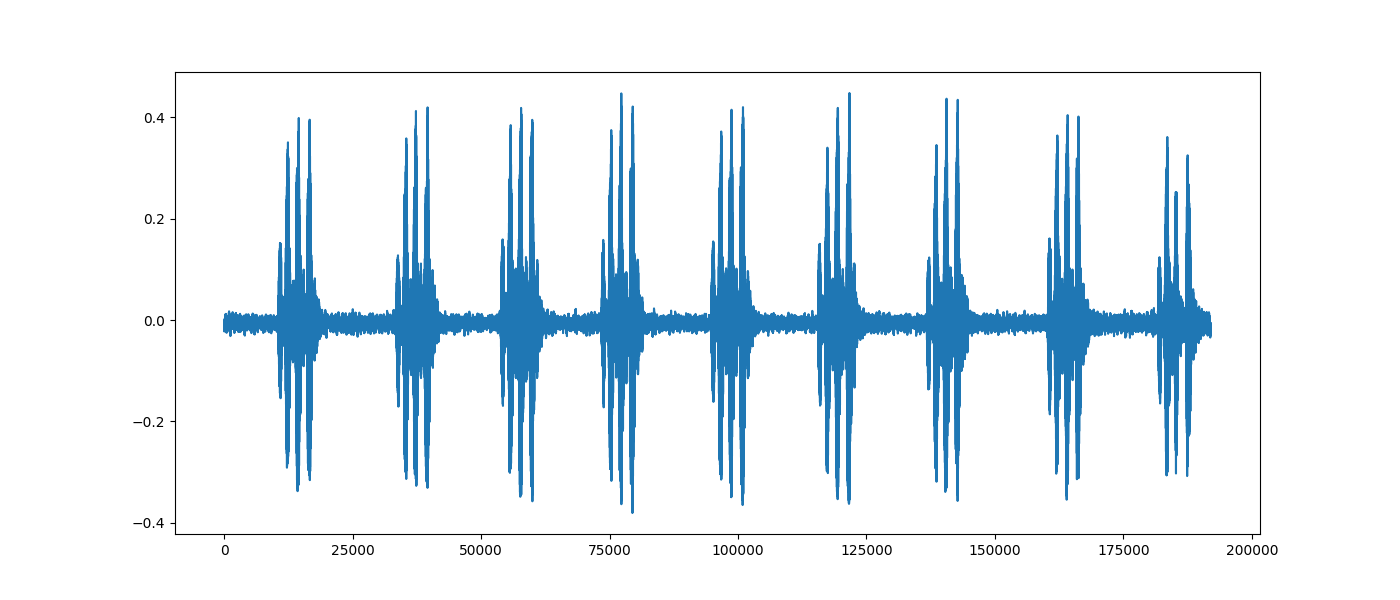

In [26]:
fig = plt.figure(figsize=(14,6))
plt.plot(audio_data[1])

<IPython.core.display.Javascript object>


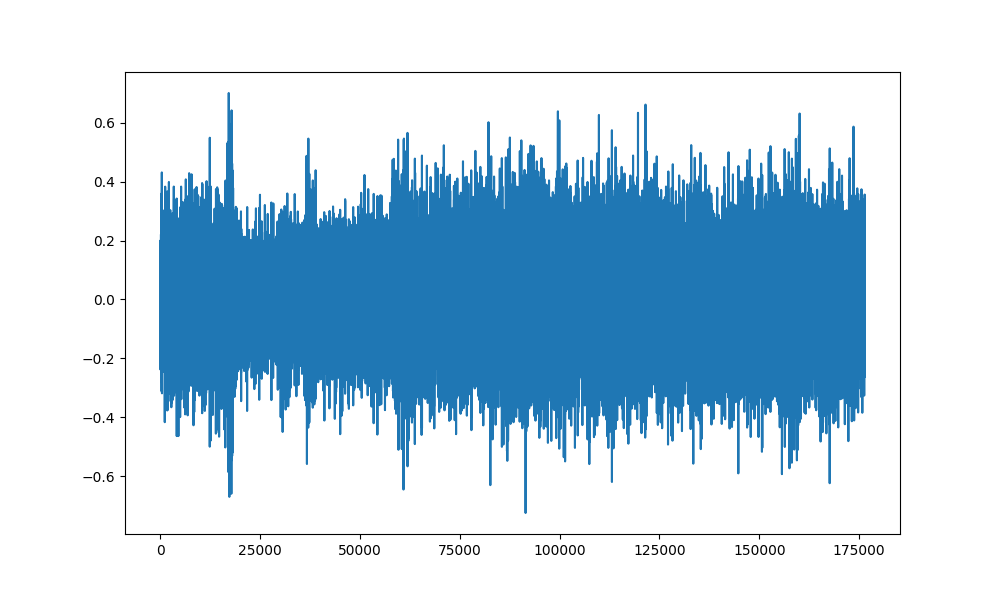

In [9]:
fig = plt.figure(figsize=(14,6))
plt.plot(audio_data[21])

In [11]:
# wavelet transform
scales = np.arange(1, 101)
coeff1, freqs1 = pywt.cwt(audio_data[1][:25000], scales, 'morl')
coeff2, freqs2 = pywt.cwt(audio_data[21][:25000], scales, 'morl')

<IPython.core.display.Javascript object>


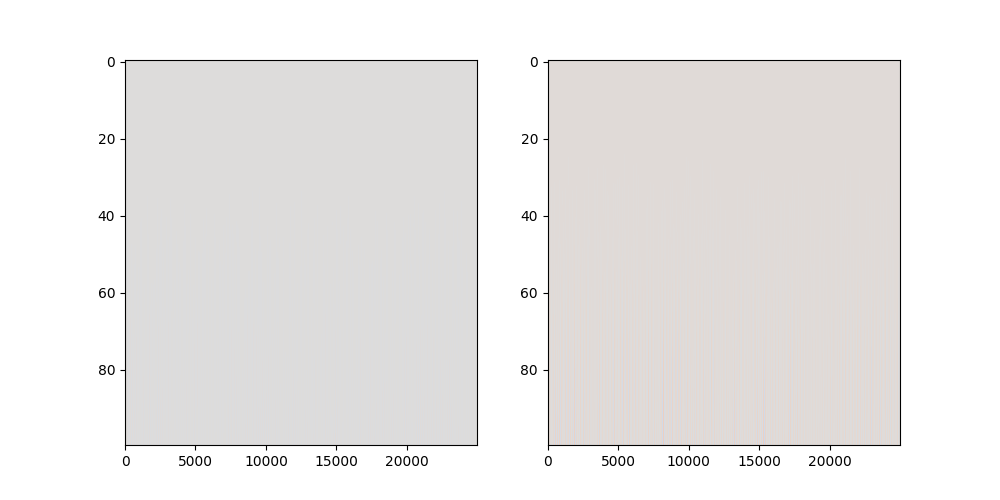

In [14]:
plt.figure(1, figsize=(20,10))
plt.subplot(121)
plt.imshow(coeff1, cmap='coolwarm', aspect='auto')  
plt.subplot(122)
plt.imshow(coeff2, cmap='coolwarm', aspect='auto')  

plt.show() 

<IPython.core.display.Javascript object>


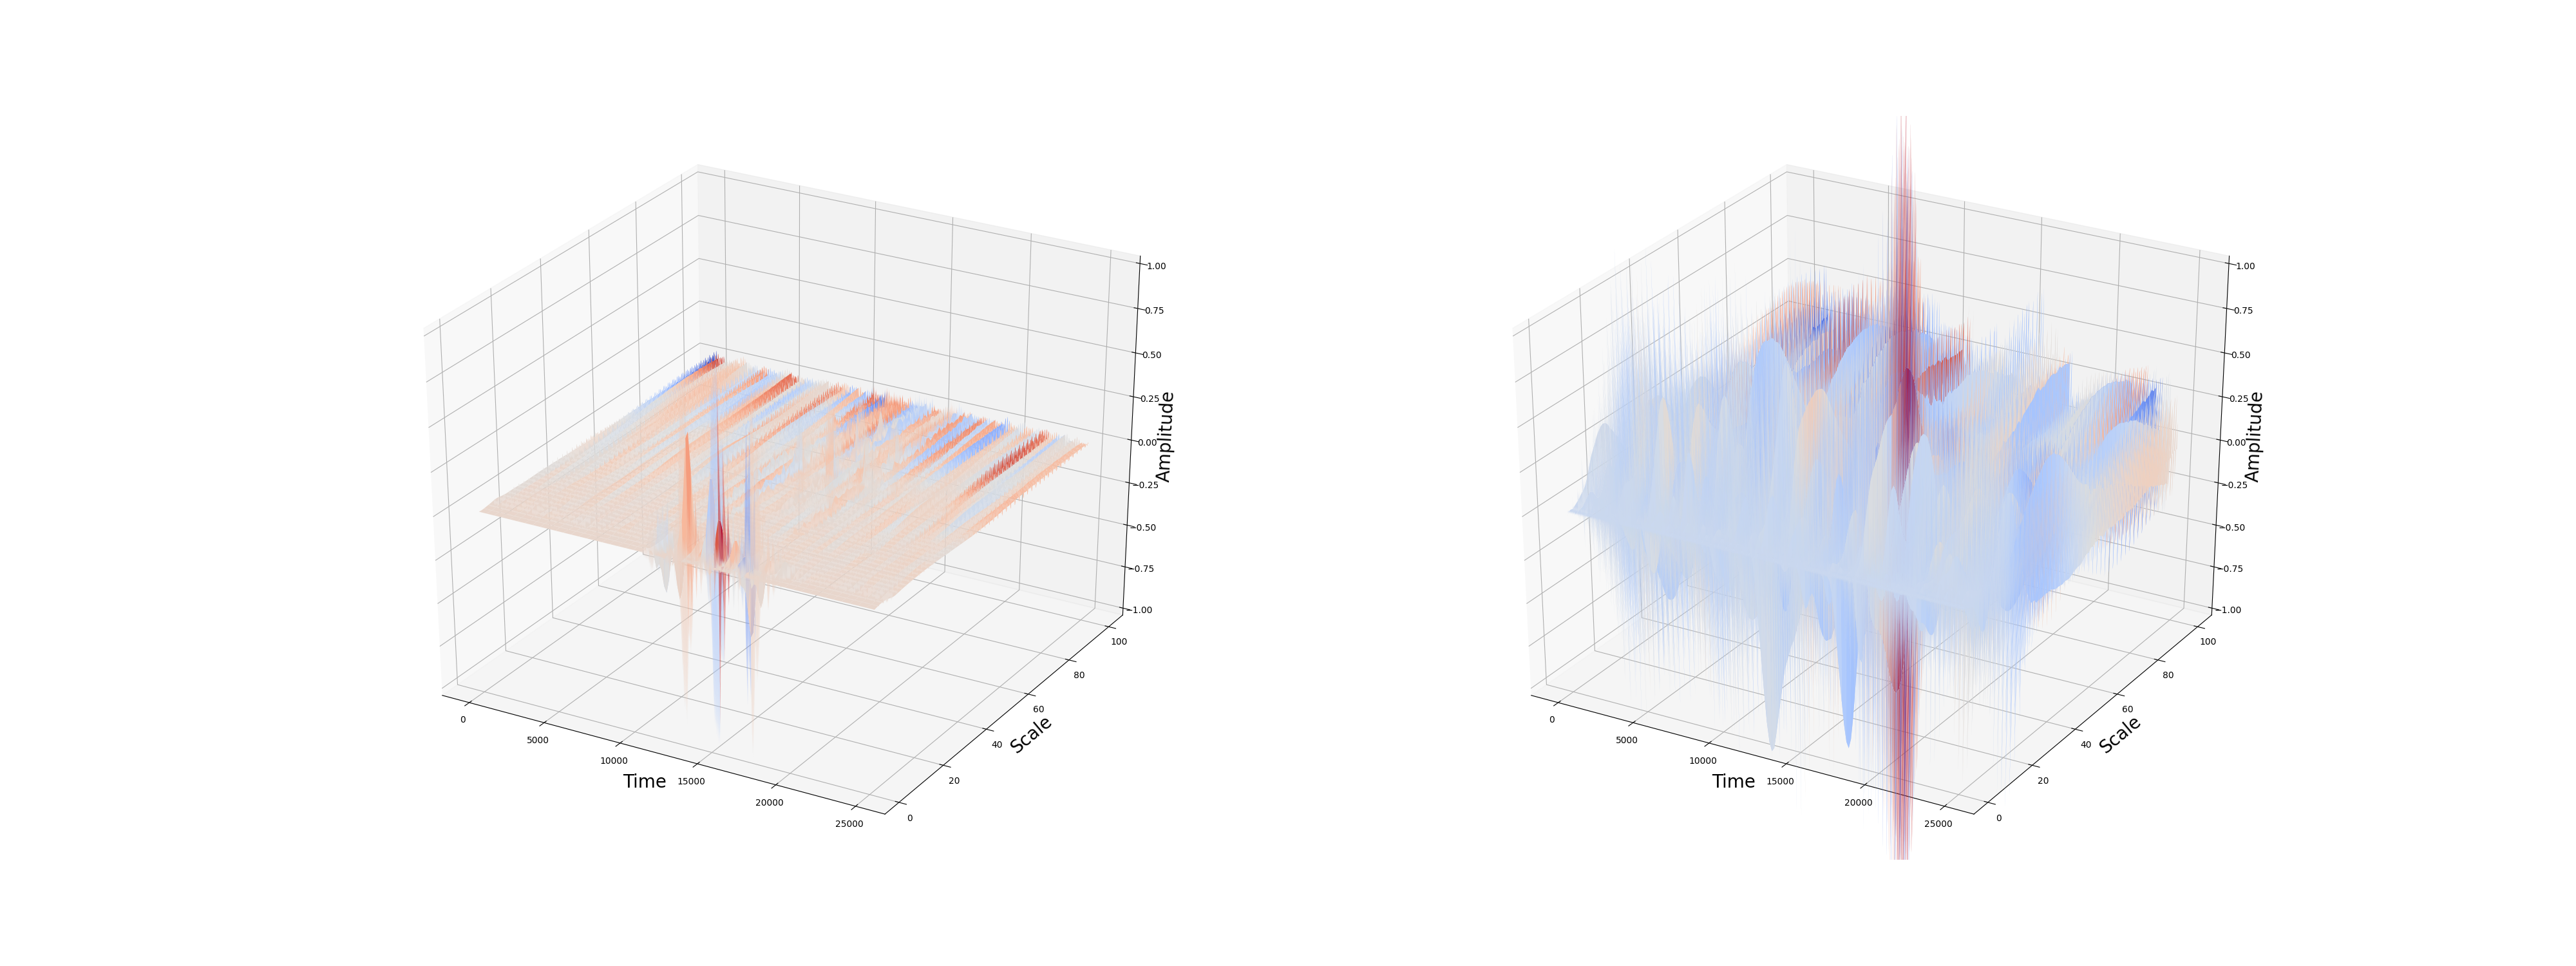

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(40,15))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

Y = np.arange(1, 101, 1)
X = np.arange(1, 25001, 1)

X, Y = np.meshgrid(X, Y)

ax1.plot_surface(X, Y, coeff1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax1.set_xlabel("Time", fontsize=20)
ax1.set_ylabel("Scale", fontsize=20)
ax1.set_zlabel("Amplitude", fontsize=20)
ax1.set_zlim3d(-1,1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.plot_surface(X, Y, coeff2, cmap=cm.coolwarm, linewidth=0, antialiased=True)


ax2.set_xlabel("Time", fontsize=20)
ax2.set_ylabel("Scale", fontsize=20)
ax2.set_zlabel("Amplitude", fontsize=20)
ax2.set_zlim3d(-1,1)

plt.show()

In [28]:
# applying PCA on the wavelet transformed audio
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

features = np.empty((0,100))

for ind in range(len(audio_data)):
    print('.', end='')
    coeff, freqs = pywt.cwt(audio_data[ind][:25000], scales, 'morl')    
    features = np.vstack([features, pca.fit_transform(coeff).flatten()])


........................................

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=1234)

In [44]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
y_pred = clf.predict(X_test)
print("Accuracy : %.2f%%" % (accuracy_score(y_test, y_pred) * 100))

Accuracy : 87.50%
